In [1]:
import numpy as np
# import matplotlib.pyplot as plt
import torch
import hypergrad as hg
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from collections import defaultdict
from progressbar import progressbar
import sys
import matplotlib.pyplot as plt
from nonsmooth_implicit_diff import data_generation, utils

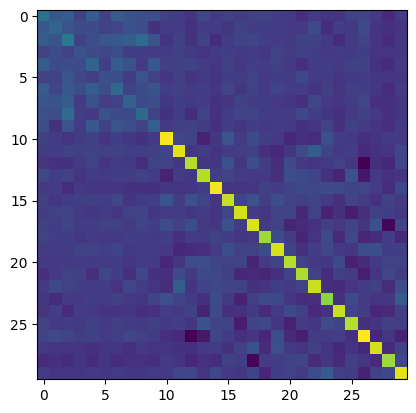

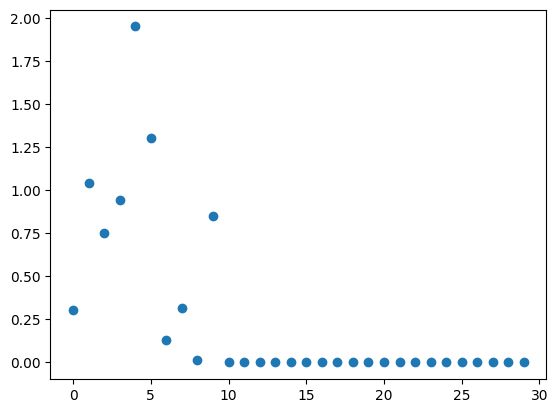

In [2]:
# Create Data
random_state = 42
X_train, X_val, X_test, y_train, y_val, y_test, w_true = data_generation.make_sparse_regression(n_samples=500, n_features=30, noise=0.1, effective_rank=5,
n_informative=10, correlated=True, shuffle=False, random_state=random_state)
                           
# Compute the covariance matrix of X
cov = X_train.T @ X_train/X_train.shape[0]

# Plot the covariance matrix
fig = plt.imshow(cov)
# fig.colorbar()
# fig.title('Covariance Matrix of X')
plt.show()

# Plot the w 
fig = plt.scatter(x=np.arange(len(w_true)), y=w_true)
# fig.title('w_true')
plt.show()
    

step_size=tensor(1.3207)
t=0: train_loss=1.1122665405273438, val_loss=tensor(0.7846), test_loss=0.43524986505508423 
t=10: train_loss=0.13919325172901154, val_loss=tensor(0.0244), test_loss=0.0192160252481699 
t=20: train_loss=0.11080577969551086, val_loss=tensor(0.0066), test_loss=0.007932920940220356 
t=30: train_loss=0.11053701490163803, val_loss=tensor(0.0062), test_loss=0.007320155389606953 
t=40: train_loss=0.11035294085741043, val_loss=tensor(0.0061), test_loss=0.007224320899695158 
t=50: train_loss=0.11020386219024658, val_loss=tensor(0.0061), test_loss=0.0072091310285031796 
t=60: train_loss=0.11008322983980179, val_loss=tensor(0.0061), test_loss=0.007206720300018787 
t=70: train_loss=0.10998541116714478, val_loss=tensor(0.0061), test_loss=0.007206333801150322 
t=80: train_loss=0.10990578681230545, val_loss=tensor(0.0061), test_loss=0.007206276059150696 
t=90: train_loss=0.10984334349632263, val_loss=tensor(0.0061), test_loss=0.007214884739369154 
t=100: train_loss=0.109796509

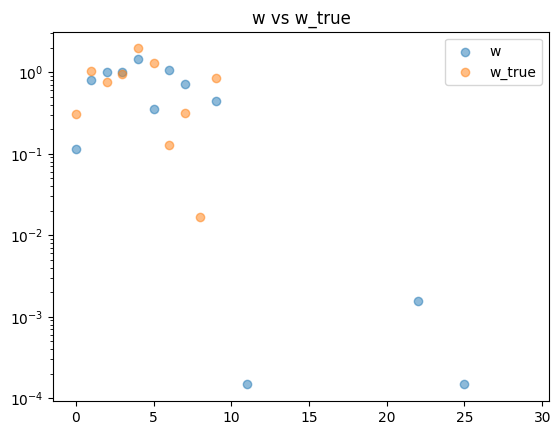

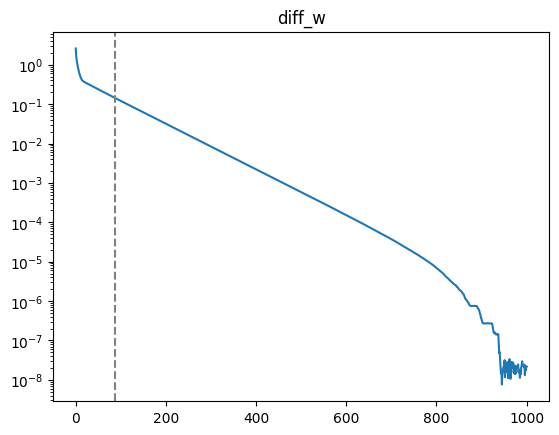

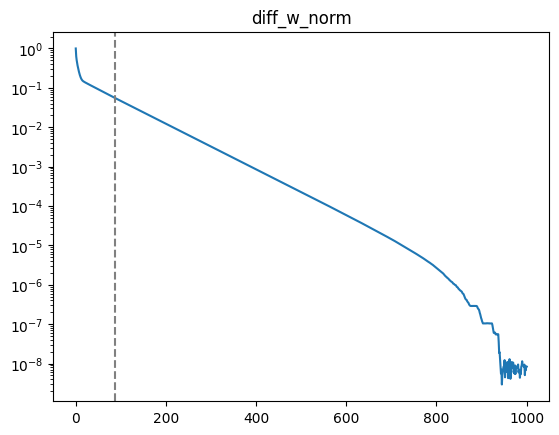

In [3]:
def loss(x, y, w):
    return  .5*torch.mean((x @ w - y)**2)

def loss_grad(x, y, w):
    return (1/len(y)) * x.T @ (x @ w - y)

def g(x, y, w, alpha):
    return loss(x, y, w) +  .5*alpha*torch.sum(w**2)

def g_grad(x, y, w, alpha):
    return loss_grad(x, y, w) + alpha * w

def h(alpha):
    return alpha*torch.sum(w.abs())

def soft_thresholding(x, alpha):
    return torch.sign(x - alpha) * torch.maximum(torch.zeros_like(x), torch.abs(x) - alpha)

def loss_reg(x, y, w, alpha_1, alpha_2):
    return  g(x, y, w, alpha_2) + h(alpha_1)

def gd_step(step_size, x, y, w, alpha):
    return w - step_size * g_grad(x, y, w, alpha)


def validation_loss(params, hparams):
    return  loss(X_val, y_val, params[0])

def get_phi(x, y, step_size):
    def phi(params, hparams):
        w = params[0]
        alpha_1, alpha_2 = hparams
        w_up = gd_step(step_size, x, y, w, alpha_2)
        # return [w_up]
        return [soft_thresholding(w_up, alpha_1)]
    return phi

def copy_tensor_list(tensor_list):
    return [tensor.detach().clone() for tensor in tensor_list]

def vectorize(tensor_list):
    def unsqueeze_maybe(t):
        if len(t.shape) == 0:
            return t.unsqueeze(dim=0)
        else:
            return t
        
    return torch.cat([unsqueeze_maybe(t) for t in tensor_list], dim=0)

def compute_opt_learning_rate(x, alpha):
    # alpha is the l2-regularization parameter
    eigenvalues, _ = np.linalg.eigh(x.T @ x)

    n = x.shape[0]
    L = np.max(eigenvalues)
    mu = np.min(eigenvalues)

    # Compute the optimal learning rate
    optimal_lr = 2 / ((L + mu)/n + 2*alpha)

    return optimal_lr

    

d = X_train.shape[-1]

alpha_1 = torch.tensor(.01)
alpha_2 = torch.tensor(0.01)
hparams = [alpha_1, alpha_2]


opt_step_size = compute_opt_learning_rate(X_train, alpha_2)
phi_opt = get_phi(X_train, y_train, opt_step_size)

params_true = [torch.zeros(d, dtype=torch.float32, requires_grad=True)]
max_iter_true = 2000
for t in range(max_iter_true):
        params_true[0].data = phi_opt(params_true, hparams)[0]
params_true = copy_tensor_list(params_true)

w = torch.zeros(d, dtype=torch.float32)
# w = 100*torch.ones(d, dtype=torch.float32)

params = [w]

# step_size = .1
step_size = compute_opt_learning_rate(X_train, alpha_2)
max_iter = 1000
eval_interval = 10
params_results = defaultdict(list)
params_history = []

print(f"{step_size=}")

phi = get_phi(X_train, y_train, step_size)


def add_results(params, t):
    params_history.append(copy_tensor_list(params))
    params_results['t'].append(t)
    params_results['w'].append(vectorize(copy_tensor_list(params)))
    params_results['diff_w'].append(torch.norm(params_results['w'][-1] -params_true[0]))
    params_results['diff_w_norm'].append(torch.norm(params_results['w'][-1] -params_true[0])/torch.norm(params_true[0]))


add_results(params, 0)
for i in range(max_iter):
     
    params[0].data = phi(params, hparams)[0]
    add_results(params, i+1)

    # eval
    if i % eval_interval == 0 or i == max_iter-1:
        train_loss = loss_reg(X_train, y_train, w, alpha_1, alpha_2).item()
        val_loss = validation_loss(params, hparams)
        test_loss = loss(X_test, y_test, w).item()

        print(f"t={i}: {train_loss=}, {val_loss=}, {test_loss=:} ")

support_ideintification_index, vec, _ = utils.when_is_support_identified(w_true=params_true[0].numpy(),
                                                                params_history=[p[0].numpy() for p in params_history])

# Plot the w 
plt.scatter(np.arange(len(w)), w.detach(),  label='w', alpha=0.5)
plt.scatter(np.arange(len(w_true)), w_true, label='w_true', alpha=0.5)
plt.title('w vs w_true')
plt.yscale('log')
plt.legend()
plt.show()

for metric in ('diff_w', 'diff_w_norm'):
    plt.title(metric)
    plt.plot(params_results['t'], params_results[metric])
    if support_ideintification_index is not None:
        plt.axvline(support_ideintification_index, color='gray', linestyle='dashed')
    plt.yscale('log')
    plt.show()



 

In [4]:
hparams = [tensor.requires_grad_(True) for tensor in copy_tensor_list(hparams)]
hypergrad_dict = defaultdict(list)

max_iter_grad = 200
eval_interval = 1
for t in progressbar(range(0, max_iter_grad+1)):
    # Compute hypergradient

    if t % eval_interval == 0:
        #hg.reverse_unroll(params_history[-1], hparams, val_loss, set_grad=True)
        grad_fixed = hg.fixed_point(params_history[t], hparams, t, phi, validation_loss)
        grad_reverse_fixed = hg.reverse([params_history[t]]*(t+1), hparams, [phi]*t, validation_loss)

        grad_reverse = hg.reverse(params_history[:t+1], hparams, [phi]*t, validation_loss)
        grad_CG = hg.CG(params_history[t], hparams, t, phi, validation_loss)       
        
        hypergrad_dict["t"].append(t)
        hypergrad_dict["ITD"].append(vectorize(grad_reverse))
        hypergrad_dict["AID-FP"].append(vectorize(grad_fixed))
        hypergrad_dict["AID-CG"].append(vectorize(grad_CG))





  0% (0 of 201) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--
  1% (3 of 201) |                        | Elapsed Time: 0:00:00 ETA:   0:00:04
  5% (11 of 201) |#                      | Elapsed Time: 0:00:00 ETA:   0:00:02
  7% (16 of 201) |#                      | Elapsed Time: 0:00:00 ETA:   0:00:02
 10% (21 of 201) |##                     | Elapsed Time: 0:00:00 ETA:   0:00:02
 11% (23 of 201) |##                     | Elapsed Time: 0:00:00 ETA:   0:00:03
 12% (26 of 201) |##                     | Elapsed Time: 0:00:00 ETA:   0:00:03
 13% (28 of 201) |###                    | Elapsed Time: 0:00:00 ETA:   0:00:03
 15% (31 of 201) |###                    | Elapsed Time: 0:00:00 ETA:   0:00:03
 16% (34 of 201) |###                    | Elapsed Time: 0:00:00 ETA:   0:00:04
 17% (36 of 201) |####                   | Elapsed Time: 0:00:00 ETA:   0:00:04
 19% (39 of 201) |####                   | Elapsed Time: 0:00:01 ETA:   0:00:04
 20% (41 of 201) |####                  

In [5]:
# compute true hypergradient
true_hypergrad = vectorize(hg.fixed_point(params_true, hparams, max_iter_true, phi_opt, validation_loss)) 
# true_hypergrad = vectorize(hg.reverse(params_history, hparams, [phi]*max_iter, validation_loss))

for hg_name in ('ITD', 'AID-FP', 'AID-CG'):
    if hg_name not in hypergrad_dict.keys():
        continue
    hypergrad_dict[f"norm_diff_{hg_name}"] = [torch.norm(h - true_hypergrad) for h in hypergrad_dict[hg_name]]
    hypergrad_dict[f"norm_diff_norm_{hg_name}"] = [torch.norm(h - true_hypergrad)/torch.norm(true_hypergrad) for h in hypergrad_dict[hg_name]]


    

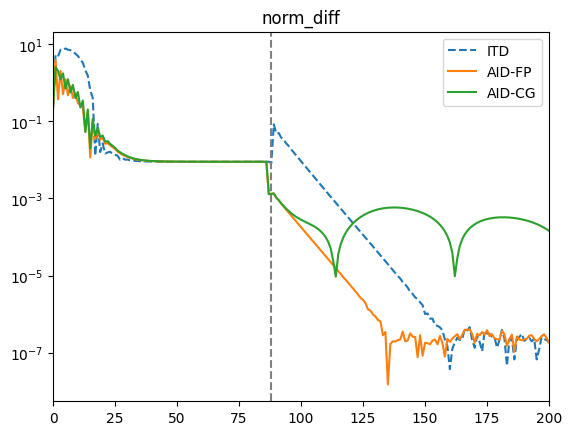

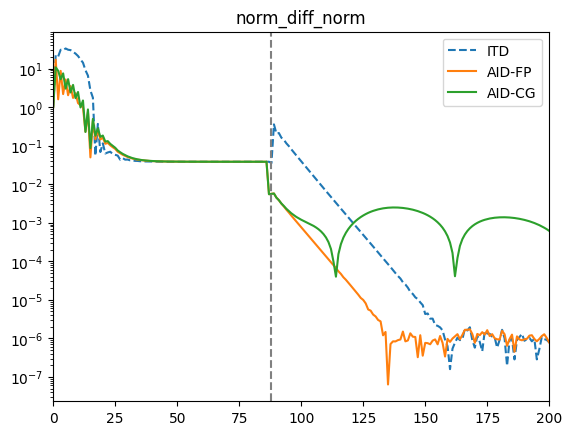

In [6]:
def plot_differnce(hypergrad_dict, mode='norm_diff'):
    plt.title(mode)
    t = hypergrad_dict['t']
    for hg_name, hg_style in (
        ('ITD', 'dashed'), 
        ('AID-FP', 'solid'), 
        ('AID-CG', 'solid'),
        ):
        if hg_name not in hypergrad_dict.keys():
            continue

        diff = hypergrad_dict[f"{mode}_{hg_name}"]
        plt.plot(t, diff, label=hg_name, linestyle=hg_style)
    if support_ideintification_index is not None:
        plt.axvline(support_ideintification_index, color='gray', linestyle='dashed')

    plt.legend()
    plt.yscale('log')

for mode in ('norm_diff', 'norm_diff_norm'):
    plot_differnce(hypergrad_dict, mode=mode)
    plt.xlim((0,200))
    plt.show()
